In [257]:
%matplotlib inline
# Dependencies and Setup
import pandas as pd
import numpy as np
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.tree import export_graphviz
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.widgets import Slider
import seaborn as sns; sns.set()
import ppscore as pps
import seaborn as seabornInstance 


In [258]:
import warnings
warnings.filterwarnings('ignore')

Read all files as indicated in subsequent cells containing data for labels and NLP formulated features of our project.

In [259]:
L_cap = pd.read_csv("./data/stock_spy.csv")
L_cap = L_cap.loc[L_cap['date']>'2016-01-01']
L_cap = L_cap.loc[:, ["date", "change"]]
L_cap.head(1)

date    change
4068  2016-01-04  0.002644

In [260]:
M_cap = pd.read_csv("./data/stock_mdy.csv")
M_cap = M_cap.loc[M_cap['date']>'2016-01-01']
M_cap = M_cap.loc[:, ["date", "change"]]
M_cap.head(1)

date    change
4068  2016-01-04  0.003601

In [261]:
S_cap = pd.read_csv("./data/stock_ijr.csv")
S_cap = S_cap.loc[S_cap['date']>'2016-01-01']
S_cap = S_cap.loc[:, ["date", "change"]]
S_cap.head(1)

date    change
3924  2016-01-04 -0.006651

In [262]:
trump_econ = pd.read_csv("./data/trump_daydf_count.csv")
trump_econ.sort_values(by=['Date'], inplace=True, ascending=True)
trump_econ.head(1)

Date  Count
540  2016-01-02      2

In [263]:
trump_favd = pd.read_csv("./data/trump_favd_count.csv")

trump_favd.head(1)

day  favorites
0  2016-01-01      68955

In [264]:
trump_sentbyday = pd.read_csv("./data/trump_sentbydaydf_count.csv")
trump_sentbyday.sort_values(by=['Date'], inplace=True, ascending=True)
trump_sentbyday.head(1)

Date  Sent_Count
1813  2016-01-01           2

In [265]:
trump_sentbydaypos = pd.read_csv("./data/trump_sentbydayposdf_count.csv")
trump_sentbydaypos.sort_values(by=['Date'], inplace=True, ascending=True)
trump_sentbydaypos.head(1)

Date  Pos_Count
1726  2016-01-01          5

In [266]:
trump_sentbydayneg = pd.read_csv("./data/trump_sentbydaynegdf_count.csv")
trump_sentbydayneg.sort_values(by=['Date'], inplace=True, ascending=True)
trump_sentbydayneg.head(1)

Date  Neg_Count
1638  2016-01-01          3

Merge all the features and label, % change of large-cap daily prices, dataframes together to form the dataframe, trump_mkt, to be used for analyses.  In additiion, a classified label 'pos_neg' is created to determine whether the stock market prices are up (1) or down (0) each day.  

In [267]:
trump_mkt = L_cap.merge(trump_sentbydayneg, how='inner', left_on="date" ,right_on="Date")
trump_mkt = trump_mkt.merge(trump_sentbydaypos, how='inner' ,on="Date")
trump_mkt = trump_mkt.merge(trump_sentbyday, how='inner' ,on="Date")
trump_mkt = trump_mkt.merge(trump_favd, how='inner' , left_on="date" ,right_on="day")
trump_mkt = trump_mkt.merge(trump_econ, how='inner' ,on="Date")
trump_mkt['pos_neg'] = np.where (trump_mkt['change'] > 0,1,0)
trump_mkt['pos'] = np.where (trump_mkt['change'] > 0.002,1,0)
trump_mkt['neg'] = np.where (trump_mkt['change'] < -0.002,1,0)
trump_mkt['flat'] = np.where ((trump_mkt['change'] <= 0.002) & (trump_mkt['change'] >= -0.002) ,1,0)

trump_mkt.head(1)

date    change        Date  Neg_Count  Pos_Count  Sent_Count  \
0  2016-01-07 -0.006553  2016-01-07          9          5          -4   

          day  favorites  Count  pos_neg  pos  neg  flat  
0  2016-01-07      58819      1        0    0    1     0

Add the monthly news releases on employment situations and quarterly real GDP estimates.  Since the data are monthly, the missing daily data are filled with the data on the immediate prior values until the new values are announced. 

In [268]:
trump_empsit = pd.read_csv("./Data/empsit.csv")
trump_empsit.head()
trump_mkt['date'] = pd.to_datetime(trump_mkt['date'])

In [269]:
trump_mkt['job_change']=np.nan
for x in range(len(trump_empsit.index)-1):
   trump_mkt.loc[((trump_mkt['date']>= trump_empsit.loc[x][0]) & (trump_mkt['date']< trump_empsit.loc[x+1][0])),['job_change']]=trump_empsit.loc[x][1]
#    print(wsb_mkt.loc[(wsb_mkt['date']>= wsb_empsit.loc[x][0]) & (wsb_mkt['date']< wsb_empsit.loc[x+1][0])]['job_change'])
trump_mkt.head(1)

date    change        Date  Neg_Count  Pos_Count  Sent_Count  \
0 2016-01-07 -0.006553  2016-01-07          9          5          -4   

          day  favorites  Count  pos_neg  pos  neg  flat  job_change  
0  2016-01-07      58819      1        0    0    1     0       237.0

In [270]:
trump_rgdp = pd.read_csv("./Data/RGDP.csv")
trump_rgdp.head()
trump_mkt['Date'] = pd.to_datetime(trump_mkt['Date'])
#trump_rgdp['Date']=pd.to_datetime(trump_rgdp['Date'])

In [271]:
trump_mkt['growthgap']=np.nan
for x in range(len(trump_rgdp.index)-1):
   trump_mkt.loc[((trump_mkt['date']>= trump_rgdp.loc[x][0]) & (trump_mkt['date']< trump_rgdp.loc[x+1][0])),['growthgap']]=trump_rgdp.loc[x][3]
trump_mkt.head(1)

date    change       Date  Neg_Count  Pos_Count  Sent_Count  \
0 2016-01-07 -0.006553 2016-01-07          9          5          -4   

          day  favorites  Count  pos_neg  pos  neg  flat  job_change  \
0  2016-01-07      58819      1        0    0    1     0       237.0   

   growthgap  
0       -0.5

<Figure size 432x288 with 0 Axes>

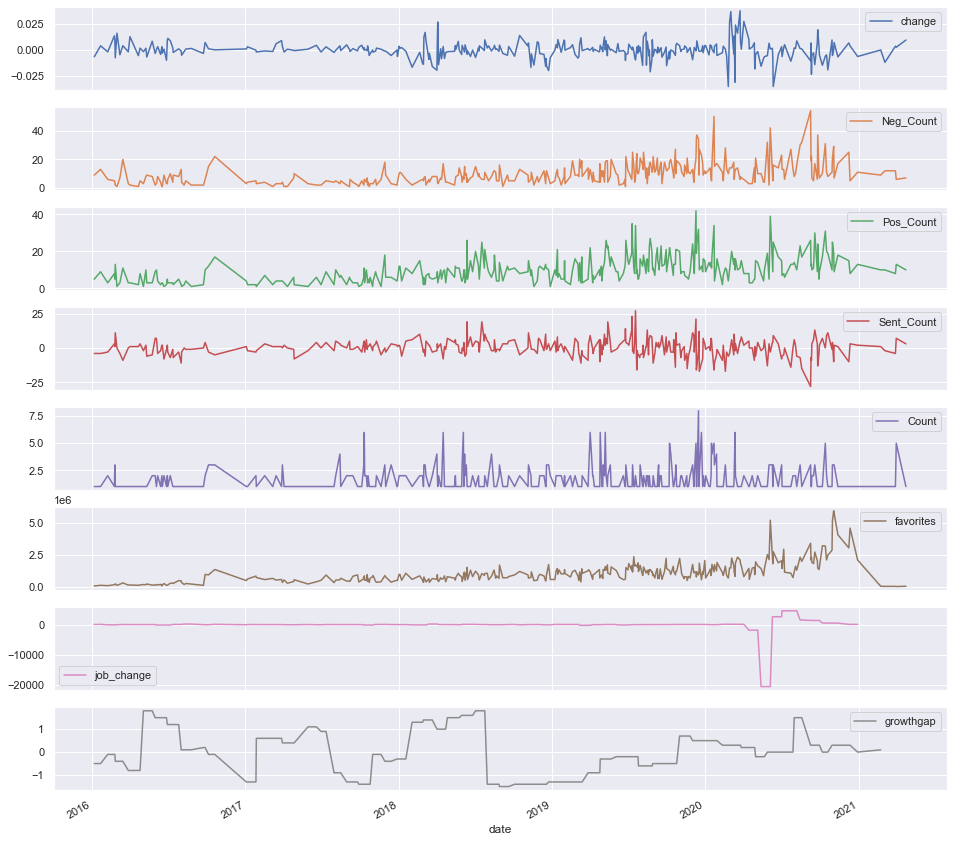

In [272]:
trump_mkt_hm1 = trump_mkt.loc[:, [
    
"date",
"change",
"Neg_Count",
"Pos_Count",
"Sent_Count",
"Count",
"favorites",
"job_change",
"growthgap"

]]
trump_mkt_hm1.set_index('date', inplace=True)
plt.subplots_adjust(bottom=0.25)
trump_mkt_hm1.plot(subplots=True, figsize=(16, 16)); plt.legend(loc='best')

Calculate Predictive Power Score

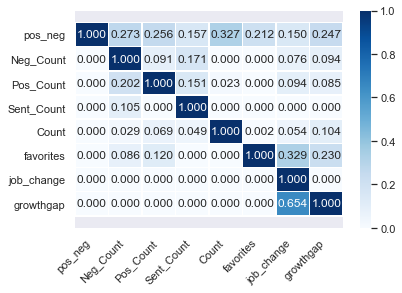

In [273]:
#pps matrix plot
trump_mkt_hm1 = trump_mkt.loc[:, [

"pos_neg",
"Neg_Count",
"Pos_Count",
"Sent_Count",
"Count",
"favorites",
"job_change",
"growthgap"]]

ax = sns.heatmap(pps.matrix(trump_mkt_hm1), vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True, fmt=".3f")
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
;

# Save Figure
plt.savefig('./Images/powell_MCap_PPS_Matrix.png', figsize=(400,240))

# Show plot
plt.show()

Given the low predictive power above, we may work on improving the predictive power by adding 15 lags of features and the % change of stock prices label to the dataframe based on the rationality that responses to remarks may take more that one day.

In [274]:
trump_mkt['negcount1day'] = trump_mkt['Neg_Count'].shift(1)
trump_mkt['poscount1day'] = trump_mkt['Pos_Count'].shift(1)
trump_mkt['sentcount1day'] = trump_mkt['Sent_Count'].shift(1)
trump_mkt['favcount1day'] = trump_mkt['favorites'].shift(1)
trump_mkt['econcount1day'] = trump_mkt['Count'].shift(1)
trump_mkt['job_change1day'] = trump_mkt['job_change'].shift(1)
trump_mkt['growthgap1day'] = trump_mkt['growthgap'].shift(1)
trump_mkt['change1day'] = trump_mkt['change'].shift(1)
trump_mkt['negcount2day'] = trump_mkt['Neg_Count'].shift(2)
trump_mkt['poscount2day'] = trump_mkt['Pos_Count'].shift(2)
trump_mkt['sentcount2day'] = trump_mkt['Sent_Count'].shift(2)
trump_mkt['favcount2day'] = trump_mkt['favorites'].shift(2)
trump_mkt['econcount2day'] = trump_mkt['Count'].shift(2)
trump_mkt['job_change2day'] = trump_mkt['job_change'].shift(2)
trump_mkt['growthgap2day'] = trump_mkt['growthgap'].shift(2)
trump_mkt['change2day'] = trump_mkt['change'].shift(2)
trump_mkt['negcount3day'] = trump_mkt['Neg_Count'].shift(3)
trump_mkt['poscount3day'] = trump_mkt['Pos_Count'].shift(3)
trump_mkt['sentcount3day'] = trump_mkt['Sent_Count'].shift(3)
trump_mkt['favcount3day'] = trump_mkt['favorites'].shift(3)
trump_mkt['econcount3day'] = trump_mkt['Count'].shift(3)
trump_mkt['job_change3day'] = trump_mkt['job_change'].shift(3)
trump_mkt['growthgap3day'] = trump_mkt['growthgap'].shift(3)
trump_mkt['change3day'] = trump_mkt['change'].shift(3)
trump_mkt['negcount4day'] = trump_mkt['Neg_Count'].shift(4)
trump_mkt['poscount4day'] = trump_mkt['Pos_Count'].shift(4)
trump_mkt['sentcount4day'] = trump_mkt['Sent_Count'].shift(4)
trump_mkt['favcount4day'] = trump_mkt['favorites'].shift(4)
trump_mkt['econcount4day'] = trump_mkt['Count'].shift(4)
trump_mkt['job_change4day'] = trump_mkt['job_change'].shift(4)
trump_mkt['growthgap4day'] = trump_mkt['growthgap'].shift(4)
trump_mkt['change4day'] = trump_mkt['change'].shift(4)
trump_mkt['negcount5day'] = trump_mkt['Neg_Count'].shift(5)
trump_mkt['poscount5day'] = trump_mkt['Pos_Count'].shift(5)
trump_mkt['sentcount5day'] = trump_mkt['Sent_Count'].shift(5)
trump_mkt['favcount5day'] = trump_mkt['favorites'].shift(5)
trump_mkt['econcount5day'] = trump_mkt['Count'].shift(5)
trump_mkt['change5day'] = trump_mkt['change'].shift(5)
trump_mkt['negcount6day'] = trump_mkt['Neg_Count'].shift(6)
trump_mkt['poscount6day'] = trump_mkt['Pos_Count'].shift(6)
trump_mkt['sentcount6day'] = trump_mkt['Sent_Count'].shift(6)
trump_mkt['favcount6day'] = trump_mkt['favorites'].shift(6)
trump_mkt['econcount6day'] = trump_mkt['Count'].shift(6)
trump_mkt['job_change6day'] = trump_mkt['job_change'].shift(6)
trump_mkt['growthgap6day'] = trump_mkt['growthgap'].shift(6)
trump_mkt['change6day'] = trump_mkt['change'].shift(6)
trump_mkt['negcount7day'] = trump_mkt['Neg_Count'].shift(7)
trump_mkt['poscount7day'] = trump_mkt['Pos_Count'].shift(7)
trump_mkt['sentcount7day'] = trump_mkt['Sent_Count'].shift(7)
trump_mkt['favcount7day'] = trump_mkt['favorites'].shift(7)
trump_mkt['econcount7day'] = trump_mkt['Count'].shift(7)
trump_mkt['job_change7day'] = trump_mkt['job_change'].shift(7)
trump_mkt['growthgap7day'] = trump_mkt['growthgap'].shift(7)
trump_mkt['change7day'] = trump_mkt['change'].shift(7)
trump_mkt['negcount8day'] = trump_mkt['Neg_Count'].shift(8)
trump_mkt['poscount8day'] = trump_mkt['Pos_Count'].shift(8)
trump_mkt['sentcount8day'] = trump_mkt['Sent_Count'].shift(8)
trump_mkt['favcount8day'] = trump_mkt['favorites'].shift(8)
trump_mkt['econcount8day'] = trump_mkt['Count'].shift(8)
trump_mkt['job_change8day'] = trump_mkt['job_change'].shift(8)
trump_mkt['growthgap8day'] = trump_mkt['growthgap'].shift(8)
trump_mkt['change8day'] = trump_mkt['change'].shift(8)
trump_mkt['negcount9day'] = trump_mkt['Neg_Count'].shift(9)
trump_mkt['poscount9day'] = trump_mkt['Pos_Count'].shift(9)
trump_mkt['sentcount9day'] = trump_mkt['Sent_Count'].shift(9)
trump_mkt['favcount9day'] = trump_mkt['favorites'].shift(9)
trump_mkt['econcount9day'] = trump_mkt['Count'].shift(9)
trump_mkt['job_change9day'] = trump_mkt['job_change'].shift(9)
trump_mkt['growthgap9day'] = trump_mkt['growthgap'].shift(9)
trump_mkt['change9day'] = trump_mkt['change'].shift(9)
trump_mkt['negcount10day'] = trump_mkt['Neg_Count'].shift(10)
trump_mkt['poscount10day'] = trump_mkt['Pos_Count'].shift(10)
trump_mkt['sentcount10day'] = trump_mkt['Sent_Count'].shift(10)
trump_mkt['favcount10day'] = trump_mkt['favorites'].shift(10)
trump_mkt['econcount10day'] = trump_mkt['Count'].shift(10)
trump_mkt['job_change10day'] = trump_mkt['job_change'].shift(10)
trump_mkt['growthgap10day'] = trump_mkt['growthgap'].shift(10)
trump_mkt['change10day'] = trump_mkt['change'].shift(10)
trump_mkt['negcount11day'] = trump_mkt['Neg_Count'].shift(11)
trump_mkt['poscount11day'] = trump_mkt['Pos_Count'].shift(11)
trump_mkt['sentcount11day'] = trump_mkt['Sent_Count'].shift(11)
trump_mkt['favcount11day'] = trump_mkt['favorites'].shift(11)
trump_mkt['econcount11day'] = trump_mkt['Count'].shift(11)
trump_mkt['job_change11day'] = trump_mkt['job_change'].shift(11)
trump_mkt['growthgap11day'] = trump_mkt['growthgap'].shift(11)
trump_mkt['change11day'] = trump_mkt['change'].shift(11)
trump_mkt['negcount12day'] = trump_mkt['Neg_Count'].shift(12)
trump_mkt['poscount12day'] = trump_mkt['Pos_Count'].shift(12)
trump_mkt['sentcount12day'] = trump_mkt['Sent_Count'].shift(12)
trump_mkt['favcount12day'] = trump_mkt['favorites'].shift(12)
trump_mkt['econcount12day'] = trump_mkt['Count'].shift(12)
trump_mkt['job_change12day'] = trump_mkt['job_change'].shift(12)
trump_mkt['growthgap12day'] = trump_mkt['growthgap'].shift(12)
trump_mkt['change12day'] = trump_mkt['change'].shift(12)
trump_mkt['negcount13day'] = trump_mkt['Neg_Count'].shift(13)
trump_mkt['poscount13day'] = trump_mkt['Pos_Count'].shift(13)
trump_mkt['sentcount13day'] = trump_mkt['Sent_Count'].shift(13)
trump_mkt['favcount13day'] = trump_mkt['favorites'].shift(13)
trump_mkt['econcount13day'] = trump_mkt['Count'].shift(13)
trump_mkt['job_change13day'] = trump_mkt['job_change'].shift(13)
trump_mkt['growthgap13day'] = trump_mkt['growthgap'].shift(13)
trump_mkt['change13day'] = trump_mkt['change'].shift(13)
trump_mkt['negcount14day'] = trump_mkt['Neg_Count'].shift(14)
trump_mkt['poscount14day'] = trump_mkt['Pos_Count'].shift(14)
trump_mkt['sentcount14day'] = trump_mkt['Sent_Count'].shift(14)
trump_mkt['favcount14day'] = trump_mkt['favorites'].shift(14)
trump_mkt['econcount14day'] = trump_mkt['Count'].shift(14)
trump_mkt['job_change14day'] = trump_mkt['job_change'].shift(14)
trump_mkt['growthgap14day'] = trump_mkt['growthgap'].shift(14)
trump_mkt['change14day'] = trump_mkt['change'].shift(14)
trump_mkt['negcount15day'] = trump_mkt['Neg_Count'].shift(15)
trump_mkt['poscount15day'] = trump_mkt['Pos_Count'].shift(15)
trump_mkt['sentcount15day'] = trump_mkt['Sent_Count'].shift(15)
trump_mkt['favcount15day'] = trump_mkt['favorites'].shift(15)
trump_mkt['econcount15day'] = trump_mkt['Count'].shift(15)
trump_mkt['job_change15day'] = trump_mkt['job_change'].shift(15)
trump_mkt['growthgap15day'] = trump_mkt['growthgap'].shift(15)
trump_mkt['change15day'] = trump_mkt['change'].shift(15)
trump_mkt.head(1)

date    change       Date  Neg_Count  Pos_Count  Sent_Count  \
0 2016-01-07 -0.006553 2016-01-07          9          5          -4   

          day  favorites  Count  pos_neg  ...  growthgap14day  change14day  \
0  2016-01-07      58819      1        0  ...             NaN          NaN   

   negcount15day  poscount15day  sentcount15day  favcount15day  \
0            NaN            NaN             NaN            NaN   

   econcount15day  job_change15day  growthgap15day  change15day  
0             NaN              NaN             NaN          NaN  

[1 rows x 133 columns]

In [275]:
trump_mkt.to_csv('./Data/trump_lmkt.csv', index=False)

In [276]:
for x in trump_mkt.columns:
    print(x)

date
change
Date
Neg_Count
Pos_Count
Sent_Count
day
favorites
Count
pos_neg
pos
neg
flat
job_change
growthgap
negcount1day
poscount1day
sentcount1day
favcount1day
econcount1day
job_change1day
growthgap1day
change1day
negcount2day
poscount2day
sentcount2day
favcount2day
econcount2day
job_change2day
growthgap2day
change2day
negcount3day
poscount3day
sentcount3day
favcount3day
econcount3day
job_change3day
growthgap3day
change3day
negcount4day
poscount4day
sentcount4day
favcount4day
econcount4day
job_change4day
growthgap4day
change4day
negcount5day
poscount5day
sentcount5day
favcount5day
econcount5day
change5day
negcount6day
poscount6day
sentcount6day
favcount6day
econcount6day
job_change6day
growthgap6day
change6day
negcount7day
poscount7day
sentcount7day
favcount7day
econcount7day
job_change7day
growthgap7day
change7day
negcount8day
poscount8day
sentcount8day
favcount8day
econcount8day
job_change8day
growthgap8day
change8day
negcount9day
poscount9day
sentcount9day
favcount9day
econcount9

Machine Learning Models: RandomForesRegression & Ridge for the model with % change of prices for SPY, MDY and IJR as labels; RandomClassifier and LogisticRegressor for the models with labels as classifiers of price change directions -- up or down. The RandomFlorest models also oberve feature importance and decision trees.

In [277]:
trump_mkt.dropna(inplace=True)
trump_lmkt_x = trump_mkt.iloc[:, np.r_[0, 3:5, 7:9, 13:15]] #1 %Change (y_3)
#trump_lmkt_x = trump_mkt.iloc[:, np.r_[0, 3:5, 7:9, 13:15]] #2 Classification Change (y_1)
#trump_lmkt_x = trump_mkt.iloc[:, np.r_[0, 3:5, 7:9]] #3 y_1 Neg_Count, Pos_Count, favorites, Count
#trump_lmkt_x = trump_mkt.iloc[:, np.r_[0, 5:6, 7:9]] #4 Sent_Count, favorites, Count
#trump_lmkt_x = trump_mkt.iloc[:, np.r_[0, 5:6, 7:8]] #4.1 Sent_Count, favorites

trump_lmkt_x.set_index("date", inplace=True)
trump_lmkt_y1 = trump_mkt['pos_neg']
#trump_lmkt_y2 = trump_mkt[['pos','neg','flat']]
trump_lmkt_y3 = trump_mkt[['change']]
trump_lmkt_x.head(1)
#trump_lmkt_x.to_csv('./Data/trump_lmkt_x.csv', index=True)
#trump_lmkt_y1.to_csv('./Data/trump_lmkt_y1.csv', index=False)

Neg_Count  Pos_Count  favorites  Count  job_change  growthgap
date                                                                     
2016-05-11          9          3     211703      1       197.0        1.8

In [278]:
X_train, X_test,y_train,y_test = train_test_split(trump_lmkt_x, trump_lmkt_y3, test_size = 0.33,random_state=42)
regr = RandomForestRegressor()
regr.fit(X_train,y_train)
print(regr.score(X_test, y_test))

#1 %Change

ridge = Ridge()
ridge.fit(X_train,y_train)
print(ridge.score(X_test, y_test))
# regr.predict_proba(X_test)

0.12673611296082243
-0.0549081729057308


In [279]:
trump_mkt.dropna(inplace=True)
#trump_lmkt_x = trump_mkt.iloc[:, np.r_[0, 3:5, 7:9, 13:15]] #1 %Change (y_3)
trump_lmkt_x = trump_mkt.iloc[:, np.r_[0, 3:5, 7:9, 13:15]] #2 Classification Change (y_1)
#trump_lmkt_x = trump_mkt.iloc[:, np.r_[0, 3:5, 7:9]] #3 y_1 Neg_Count, Pos_Count, favorites, Count
#trump_lmkt_x = trump_mkt.iloc[:, np.r_[0, 5:6, 7:9]] #4 Sent_Count, favorites, Count
#trump_lmkt_x = trump_mkt.iloc[:, np.r_[0, 5:6, 7:8]] #4.1 Sent_Count, favorites

trump_lmkt_x.set_index("date", inplace=True)
trump_lmkt_y1 = trump_mkt['pos_neg']
#trump_lmkt_y2 = trump_mkt[['pos','neg','flat']]
trump_lmkt_y3 = trump_mkt[['change']]
trump_lmkt_x.head(1)
#trump_lmkt_x.to_csv('./Data/trump_lmkt_x.csv', index=True)
#trump_lmkt_y1.to_csv('./Data/trump_lmkt_y1.csv', index=False)

Neg_Count  Pos_Count  favorites  Count  job_change  growthgap
date                                                                     
2016-05-11          9          3     211703      1       197.0        1.8

In [280]:
X_train, X_test,y_train,y_test = train_test_split(trump_lmkt_x, trump_lmkt_y1, test_size = 0.33,random_state=42)
regr = RandomForestRegressor()
regr.fit(X_train,y_train)
print(regr.score(X_test, y_test))

#2 Pos_Count, Neg_Count, Count, job_change, growthgap

ridge = Ridge()
ridge.fit(X_train,y_train)
print(ridge.score(X_test, y_test))
# regr.predict_proba(X_test)

-0.3822131661442008
-0.07834481219050216


In [281]:
trump_mkt.dropna(inplace=True)
#trump_lmkt_x = trump_mkt.iloc[:, np.r_[0, 3:5, 7:9, 13:15]] #1 %Change (y_3)
#trump_lmkt_x = trump_mkt.iloc[:, np.r_[0, 3:5, 7:9, 13:15]] #2 Classification Change (y_1)
trump_lmkt_x = trump_mkt.iloc[:, np.r_[0, 3:5, 7:9]] #3 y_1 Neg_Count, Pos_Count, favorites, Count
#trump_lmkt_x = trump_mkt.iloc[:, np.r_[0, 5:6, 7:9]] #4 Sent_Count, favorites, Count
#trump_lmkt_x = trump_mkt.iloc[:, np.r_[0, 5:6, 7:8]] #4.1 Sent_Count, favorites

trump_lmkt_x.set_index("date", inplace=True)
trump_lmkt_y1 = trump_mkt['pos_neg']
#trump_lmkt_y2 = trump_mkt[['pos','neg','flat']]
trump_lmkt_y3 = trump_mkt[['change']]
trump_lmkt_x.head(1)
#trump_lmkt_x.to_csv('./Data/trump_lmkt_x.csv', index=True)
#trump_lmkt_y1.to_csv('./Data/trump_lmkt_y1.csv', index=False)

Neg_Count  Pos_Count  favorites  Count
date                                              
2016-05-11          9          3     211703      1

In [282]:
X_train, X_test,y_train,y_test = train_test_split(trump_lmkt_x, trump_lmkt_y1, test_size = 0.33,random_state=42)
regr = RandomForestRegressor()
regr.fit(X_train,y_train)
print(regr.score(X_test, y_test))

#3 Pos_Count, Neg_Count, favorites, Count

ridge = Ridge()
ridge.fit(X_train,y_train)
print(ridge.score(X_test, y_test))
# regr.predict_proba(X_test)

-0.3489153605015673
-0.07525425409774078


In [292]:
trump_mkt.dropna(inplace=True)
#trump_lmkt_x = trump_mkt.iloc[:, np.r_[0, 3:5, 7:9, 13:15]] #1 %Change (y_3)
#trump_lmkt_x = trump_mkt.iloc[:, np.r_[0, 3:5, 7:9, 13:15]] #2 Classification Change (y_1)
#trump_lmkt_x = trump_mkt.iloc[:, np.r_[0, 3:5, 7:9]] #3 y_1 Neg_Count, Pos_Count, favorites, Count
#trump_lmkt_x = trump_mkt.iloc[:, np.r_[0, 5:6, 7:9]] #4 Sent_Count, favorites, Count
trump_lmkt_x = trump_mkt.iloc[:, np.r_[0, 5:6, 7:8]] #4.1 Sent_Count, favorites
#trump_lmkt_x = trump_mkt.iloc[:, np.r_[0, 2:4, 5:7, 11:13]] #3 Neg_Count, Pos_Count, job_change, growthgap
#trump_lmkt_x = trump_mkt.iloc[:, np.r_[0, 2:4, 5:7, 11:13, 13:15, 16:23, 24:31, 32:39, 40:47, 48 -55, 56:63, 64:71, 72:79, 80:87, 88:95, 96:103, 104:111, 112:119, 120:127, 128:133]] #4 with lags
trump_lmkt_x.set_index("date", inplace=True)
trump_lmkt_y1 = trump_mkt['pos_neg']
#trump_lmkt_y2 = trump_mkt[['pos','neg','flat']]
trump_lmkt_y3 = trump_mkt[['change']]
trump_lmkt_x.head(1)
#trump_lmkt_x.to_csv('./Data/trump_lmkt_x.csv', index=True)
#trump_lmkt_y1.to_csv('./Data/trump_lmkt_y1.csv', index=False)

Sent_Count  favorites
date                             
2016-05-11          -6     211703

In [293]:
X_train, X_test,y_train,y_test = train_test_split(trump_lmkt_x, trump_lmkt_y1, test_size = 0.33,random_state=42)
regr = RandomForestRegressor()
regr.fit(X_train,y_train)
print(regr.score(X_test, y_test))

#4.1 Sent_Count

ridge = Ridge()
ridge.fit(X_train,y_train)
print(ridge.score(X_test, y_test))
# regr.predict_proba(X_test)

-0.2702758620689656
-0.019765349693728895


In [289]:
X_train, X_test,y_train,y_test = train_test_split(trump_lmkt_x, trump_lmkt_y1, test_size = 0.33,random_state=42)
regr = RandomForestRegressor()
regr.fit(X_train,y_train)
print(regr.score(X_test, y_test))

#4 Sent_Count, favorites, Count

ridge = Ridge()
ridge.fit(X_train,y_train)
print(ridge.score(X_test, y_test))
# regr.predict_proba(X_test)

-0.263899686520376
-0.008810348992658534


In [306]:
trump_mkt.dropna(inplace=True)

#trump_lmkt_x = trump_mkt.iloc[:, np.r_[0, 3:5, 7:9, 13:17, 18:23]] #5.1 with 1 lag
trump_lmkt_x = trump_mkt.iloc[:, np.r_[0, 3:5, 7:9, 13:17, 18:23]] #5 with 1 lag
#trump_lmkt_x = trump_mkt.iloc[:, np.r_[0, 3:5, 7:9, 13:17, 18:25, 26:33, 34:41, 42:49, 50:55, 56:63, 64:69]] #6 with 7 lags
#trump_lmkt_x = trump_mkt.iloc[:, np.r_[0, 3:5, 7:9, 13:17, 18:25, 26:33, 34:41, 42:49, 50:55, 56:63, 64:71, 72:79, 80:87, 88:95, 96:103, 104:111, 112:119, 120:127, 128:133]] #7 with 15 lags

trump_lmkt_x.set_index("date", inplace=True)
trump_lmkt_y1 = trump_mkt['pos_neg']
#trump_lmkt_y2 = trump_mkt[['pos','neg','flat']]
trump_lmkt_y3 = trump_mkt[['change']]
trump_lmkt_x.head(1)
#trump_lmkt_x.to_csv('./Data/trump_lmkt_x.csv', index=True)
#trump_lmkt_y1.to_csv('./Data/trump_lmkt_y1.csv', index=False)

Neg_Count  Pos_Count  favorites  Count  job_change  growthgap  \
date                                                                        
2016-05-11          9          3     211703      1       197.0        1.8   

            negcount1day  poscount1day  favcount1day  econcount1day  \
date                                                                  
2016-05-11           8.0          10.0      159922.0            1.0   

            job_change1day  growthgap1day  change1day  
date                                                   
2016-05-11           197.0            1.8    0.001557

In [309]:
X_train, X_test,y_train,y_test = train_test_split(trump_lmkt_x, trump_lmkt_y1, test_size = 0.33,random_state=42)
regr = RandomForestRegressor()
regr.fit(X_train,y_train)
print(regr.score(X_test, y_test))

#5 with 1 lag

ridge = Ridge()
ridge.fit(X_train,y_train)
print(ridge.score(X_test, y_test))
# regr.predict_proba(X_test)

sorted(zip(regr.feature_importances_, trump_mkt.iloc[:, np.r_[3:5, 6:7, 13:17, 18:23]]), reverse=True)

-0.13779310344827578
-0.08553021834039964


[(0.10564515530113612, 'econcount1day'),
 (0.09346833187041624, 'Pos_Count'),
 (0.09012792721085602, 'poscount1day'),
 (0.08775380352006279, 'day'),
 (0.08449072112537033, 'Neg_Count'),
 (0.07809929486160823, 'growthgap'),
 (0.06792780863636326, 'job_change'),
 (0.06281239460750146, 'growthgap1day'),
 (0.0539430125564647, 'favcount1day'),
 (0.04708165230599056, 'negcount1day'),
 (0.043293771273940754, 'change1day'),
 (0.016469140186589463, 'job_change1day')]

In [305]:
X_train, X_test,y_train,y_test = train_test_split(trump_lmkt_x, trump_lmkt_y1, test_size = 0.33,random_state=42)
regr = RandomForestRegressor()
regr.fit(X_train,y_train)
print(regr.score(X_test, y_test))

#6 with 7 lags

ridge = Ridge()
ridge.fit(X_train,y_train)
print(ridge.score(X_test, y_test))
# regr.predict_proba(X_test)

sorted(zip(regr.feature_importances_, trump_mkt.iloc[:, np.r_[3:5, 7:9, 13:17, 18:25, 26:33, 34:41, 42:49, 50:55, 56:63, 64:69]]), reverse=True)

-0.043213166144200565
-0.6626139638348352


[(0.05991310268813316, 'change5day'),
 (0.048576756977569795, 'favcount5day'),
 (0.04358681290399031, 'negcount7day'),
 (0.041199675791731595, 'poscount4day'),
 (0.03717744397844285, 'negcount5day'),
 (0.03525901299352946, 'favcount1day'),
 (0.033867062166924276, 'change3day'),
 (0.03290318758605207, 'change6day'),
 (0.032109593347619224, 'negcount1day'),
 (0.03148329590522592, 'change4day'),
 (0.030029524037731653, 'negcount3day'),
 (0.027769393298204947, 'poscount7day'),
 (0.027322968670128844, 'favorites'),
 (0.026490277796654776, 'poscount6day'),
 (0.02626253251089003, 'Count'),
 (0.025821493597947224, 'favcount7day'),
 (0.025048083143700176, 'change2day'),
 (0.023612853946002408, 'favcount2day'),
 (0.0231111670400665, 'growthgap7day'),
 (0.021951245894382326, 'negcount2day'),
 (0.020530320127014685, 'Neg_Count'),
 (0.019948068574266484, 'econcount3day'),
 (0.019080293851360182, 'change7day'),
 (0.01906871777157052, 'favcount3day'),
 (0.018276623999584015, 'negcount4day'),
 (0.0182

In [302]:
X_train, X_test,y_train,y_test = train_test_split(trump_lmkt_x, trump_lmkt_y1, test_size = 0.33,random_state=42)
regr = RandomForestRegressor()
regr.fit(X_train,y_train)
print(regr.score(X_test, y_test))

#7 with 15 lags

ridge = Ridge()
ridge.fit(X_train,y_train)
print(ridge.score(X_test, y_test))
# regr.predict_proba(X_test)

sorted(zip(regr.feature_importances_, trump_mkt.iloc[:, np.r_[3:5, 7:9, 13:17, 18:25, 26:33, 34:41, 42:49, 50:55, 56:63, 64:71, 72:79, 80:87, 88:95, 96:103, 104:111, 112:119, 120:127, 128:133]]), reverse=True)

-0.20438871473354236
-9.659900755872082


[(0.07376065924335724, 'change13day'),
 (0.04388583146869176, 'change1day'),
 (0.03862211376637253, 'change5day'),
 (0.03372591927277102, 'negcount9day'),
 (0.03305442298494491, 'favcount13day'),
 (0.032585948724642044, 'favcount11day'),
 (0.030966846348849365, 'favorites'),
 (0.028727658239803805, 'favcount10day'),
 (0.02583493067104784, 'negcount1day'),
 (0.024496313931182248, 'change14day'),
 (0.02298960351075959, 'favcount14day'),
 (0.022668020500815282, 'change9day'),
 (0.021386423723269536, 'poscount12day'),
 (0.020649242132078232, 'job_change13day'),
 (0.0205465013421023, 'change3day'),
 (0.019301277061835227, 'change11day'),
 (0.019013929961750962, 'growthgap10day'),
 (0.018524181345691473, 'job_change6day'),
 (0.01852187714179381, 'favcount8day'),
 (0.01675957567355637, 'negcount13day'),
 (0.0162679801287547, 'poscount1day'),
 (0.014635413251953052, 'job_change14day'),
 (0.014491367233398746, 'econcount11day'),
 (0.014108654594916498, 'favcount3day'),
 (0.01348044858871451, 'p